In [76]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs


fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [77]:
!ls german-traffic-signs


signnames.csv  test.p  train.p	valid.p


In [78]:
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [80]:
np.random.seed(0)

In [81]:
# Implement load the data here.

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

print(type(train_data))

<class 'dict'>


In [82]:
# Split out features and labels

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [83]:
print(X_train.shape)           # no. of images * pixels * pixels * depth
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [84]:
# To check if the images are correctly labled

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [85]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)
#print(data.head)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

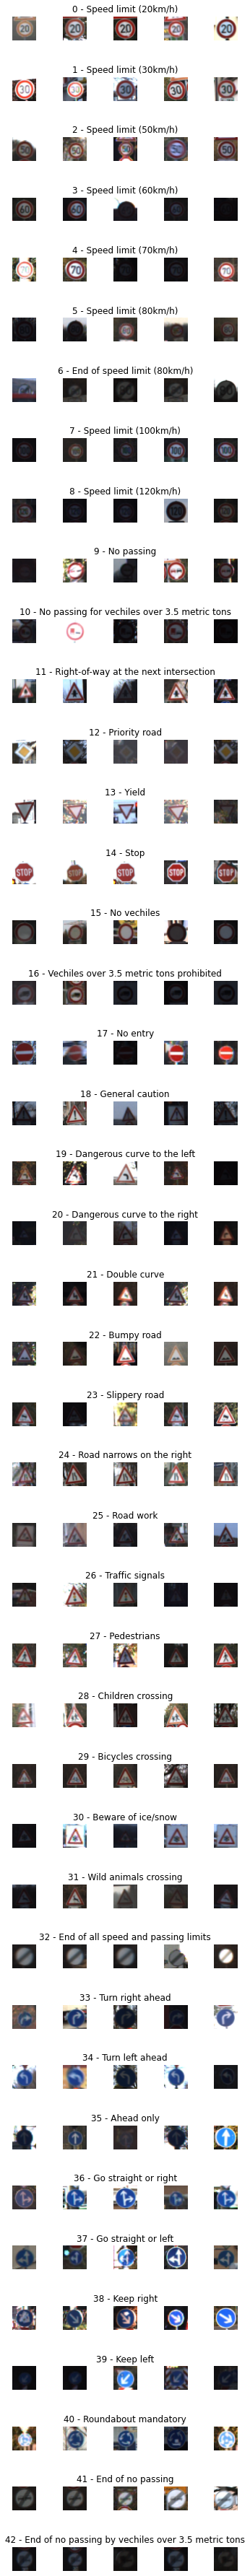

In [86]:
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


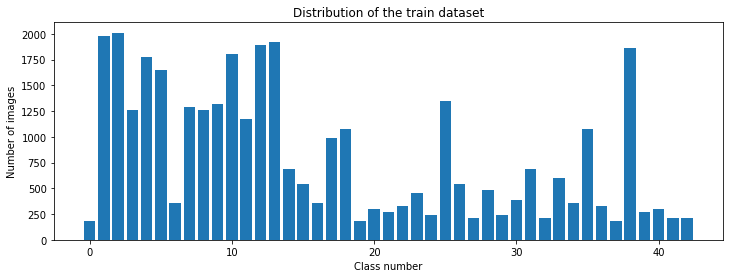

In [87]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
#plt.grid()
plt.show()

# As we can see, some classes have more images and some of then have less images. 

(32, 32, 3)
36


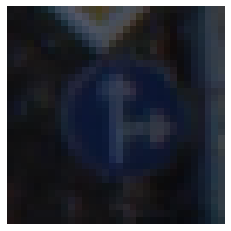

In [88]:
# Preprocessing the images is required as, diffrent images has differnt background and unique features
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


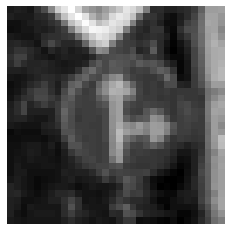

In [89]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img
#plt.imshow(img)
img = grayscale(X_train[1000])
plt.imshow(img,cmap=plt.get_cmap('gray'))                                                     
plt.axis("off")
print(img.shape)


(32, 32)


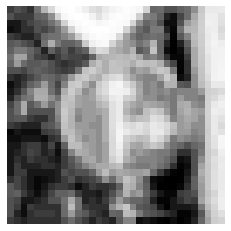

In [90]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [91]:
def preprocess(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255    # Normalisation = All pixel values are normalised between 0 and 1
  return img 


In [92]:
# Preprocessing train,val,test data sets in a sequence

# map() = Iterate through the entire array and for every element of the array, returns a new element based on the specified function 
# creating a new array with updated values.
#list() = is used to store the return values of map().

X_train = np.array(list(map(preprocess, X_train)))    
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 

(34799, 32, 32)


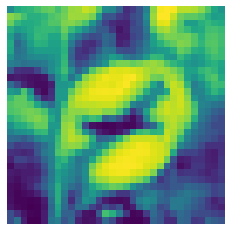

In [93]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
#plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [94]:
# We add depth to a greyscale image, as CNN requires depth value
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [95]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [96]:
# One-hot encoding

y_train = to_categorical(y_train, 43)    # for 43 classes
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [97]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(30,(5,5),input_shape = (32,32,1),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(15, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))

  #Compile model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model


In [98]:
model = leNet_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 30)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 540)               0         
                                                                 
 dense_8 (Dense)             (None, 500)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [99]:
model.fit(X_train,y_train, epochs = 10, validation_data=(X_val,y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 3s 19ms/step - loss: 2.5851 - accuracy: 0.3212 - val_loss: 1.2941 - val_accuracy: 0.6234
Epoch 2/10
87/87 [==============================] - 1s 9ms/step - loss: 0.8923 - accuracy: 0.7258 - val_loss: 0.6364 - val_accuracy: 0.8014
Epoch 3/10
87/87 [==============================] - 1s 9ms/step - loss: 0.4867 - accuracy: 0.8526 - val_loss: 0.4247 - val_accuracy: 0.8662
Epoch 4/10
87/87 [==============================] - 1s 9ms/step - loss: 0.3299 - accuracy: 0.9027 - val_loss: 0.3588 - val_accuracy: 0.8864
Epoch 5/10
87/87 [==============================] - 1s 9ms/step - loss: 0.2486 - accuracy: 0.9267 - val_loss: 0.2901 - val_accuracy: 0.9086
Epoch 6/10
87/87 [==============================] - 1s 10ms/step - loss: 0.1940 - accuracy: 0.9433 - val_loss: 0.2749 - val_accuracy: 0.9073
Epoch 7/10
87/87 [==============================] - 1s 9ms/step - loss: 0.1577 - accuracy: 0.9532 - val_loss: 0.2663 - val_accuracy: 0.9120
Epoch 8/10
87/87 [

In [100]:
history = model.fit(X_train, y_train, epochs=10, batch_size=400 ,validation_data=(X_val, y_val), verbose=1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 1s 12ms/step - loss: 0.0839 - accuracy: 0.9756 - val_loss: 0.1991 - val_accuracy: 0.9383
Epoch 2/10
87/87 [==============================] - 1s 13ms/step - loss: 0.0759 - accuracy: 0.9776 - val_loss: 0.2091 - val_accuracy: 0.9356
Epoch 3/10
87/87 [==============================] - 1s 13ms/step - loss: 0.0649 - accuracy: 0.9805 - val_loss: 0.2230 - val_accuracy: 0.9331
Epoch 4/10
87/87 [==============================] - 1s 13ms/step - loss: 0.0573 - accuracy: 0.9834 - val_loss: 0.2112 - val_accuracy: 0.9356
Epoch 5/10
87/87 [==============================] - 1s 11ms/step - loss: 0.0517 - accuracy: 0.9855 - val_loss: 0.1881 - val_accuracy: 0.9456
Epoch 6/10
87/87 [==============================] - 1s 12ms/step - loss: 0.0479 - accuracy: 0.9860 - val_loss: 0.1860 - val_accuracy: 0.9449
Epoch 7/10
87/87 [==============================] - 1s 12ms/step - loss: 0.0419 - accuracy: 0.9876 - val_loss: 0.1793 - val_accuracy: 0.9467
Epoch 8/10
87

Text(0.5, 0, 'epoch')

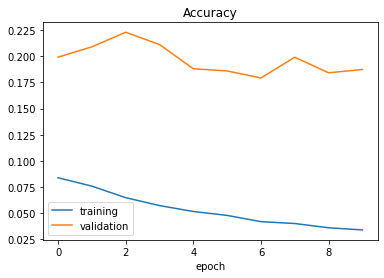

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

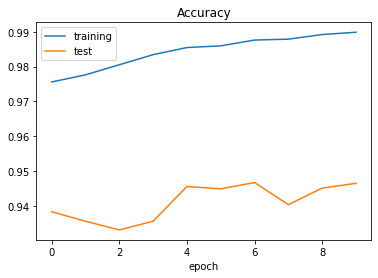

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [103]:
# To Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.3324570953845978
Test accuracy: 0.9294536709785461


In [104]:
"""
It can be seen that the performance of leNet model is not very good.
We see that the loss is even higher at a minimum value of about 0.9.
Let's make sure that point 0.9 and the validation loss is even higher at about 0.25, but it's pretty high.

And moving on to accuracy, we see that we get a training accuracy of about 0.8828 while
our validation accuracy seems to lag behind.

These values imply that the network is not performing effectively in terms of accurately predicting
images from the dataset.

The network seems to have overfit in our data as well.
This can be seen visibly in the graphs due to the fact that validation accuracy is trailing behind
the training accuracy.

Evaluating the model also shows that the network is not at peak performance.
It has a relatively low accuracy rating.
So fine tunning is needed the model to improve its performance.

The traffic sign data seems more difficult to classify
due to fewer training images, more complex data and a much higher number of classes in which these
traffic signs are being classified and also noting the non-uniform distribution and images that we have.




Conclusion:
  The two main issues are,

  Firstly, the accuracy is not as high as needed.
  And secondly, the network seems to be overfitting the training data.

"""

"\nIt can be seen that the performance of leNet model is not very good.\nWe see that the loss is even higher at a minimum value of about 0.9.\nLet's make sure that point 0.9 and the validation loss is even higher at about 0.25, but it's pretty high.\n\nAnd moving on to accuracy, we see that we get a training accuracy of about 0.8828 while\nour validation accuracy seems to lag behind.\n\nThese values imply that the network is not performing effectively in terms of accurately predicting\nimages from the dataset.\n\nThe network seems to have overfit in our data as well.\nThis can be seen visibly in the graphs due to the fact that validation accuracy is trailing behind\nthe training accuracy.\n\nEvaluating the model also shows that the network is not at peak performance.\nIt has a relatively low accuracy rating.\nSo fine tunning is needed the model to improve its performance.\n\nThe traffic sign data seems more difficult to classify\ndue to fewer training images, more complex data and a mu

In [105]:
# When we trained the same model with learning rate lr=0.001, ading extra dopout layer, and incresed filter size to 60,
# the accuracy was improved.
#  Training accuracy: 0.9880,  val_loss: 0.2239 , val_accuracy: 0.9454

In [ ]:
# The same model is modified by adding extra layers, and dropout layers to reduce overfitting.
# The accuracy was improved even more.
"""

def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))

  #Compile model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

"""